In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [71]:
# Configs
plt.rcParams["figure.figsize"] = (20, 5)
PRODUCT = "DOLPHIN_SIGHTINGS"
SYMBOL = "DOLPHIN_SIGHTINGS"
START_DAY = 0
END_DAY = 3

In [72]:
def prices_files(round: int, start: int, end: int):
    return [f"../data/island-data-bottle-round-{round}/prices_round_{round}_day_{i}.csv" for i in range(start, end+1)]
def trades_files(round: int, start: int, end: int):
    return [f"../data/island-data-bottle-round-{round}/trades_round_{round}_day_{i}_nn.csv" for i in range(start, end+1)]

rd_1_price_files, rd_1_trade_files = prices_files(1, -2, -2), trades_files(1, -2, -2)
rd_2_price_files, rd_2_trade_files = prices_files(2, -1, 1), trades_files(2, -1, 1)
rd_3_price_files, rd_3_trade_files = prices_files(3, 0, 2), trades_files(3, 0, 2)

all_price_files = rd_1_price_files + rd_2_price_files + rd_3_price_files
all_trade_files = rd_1_trade_files + rd_2_trade_files + rd_3_trade_files

In [73]:
def get_prices_df(product):
    prices_df = pd.concat((pd.read_csv(filename, sep=";", usecols=lambda x: x not in ["day", "profit_and_loss"], index_col=["timestamp"]) for filename in all_price_files), axis="index").query(f"product == '{product}'").reset_index(drop=True)
    prices_df.insert(0, "timestamp", prices_df.index * 100)
    prices_df.set_index("timestamp", inplace=True)
    return prices_df

def get_trades_df(symbol):
    trades_df = pd.concat((pd.read_csv(filename, sep=";", usecols=lambda x : x not in ["buyer", "seller", "currency"], index_col=["timestamp"]) for filename in all_trade_files)).query(f"symbol == '{symbol}'").reset_index(drop=True)
    trades_df.insert(0, "timestamp", trades_df.index)
    trades_df.set_index("timestamp", inplace=True)
    return trades_df

In [74]:
prices_df = get_prices_df(PRODUCT).fillna(0)
prices_df.insert(7, "bid_volume", prices_df["bid_volume_1"] + prices_df["bid_volume_2"] + prices_df["bid_volume_3"])
prices_df.insert(14, "ask_volume", - prices_df["ask_volume_1"] - prices_df["ask_volume_2"] - prices_df["ask_volume_3"])
prices_df["diff_volume"] = prices_df["bid_volume"] + prices_df["ask_volume"]
prices_df

,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,bid_volume,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,ask_volume,mid_price,diff_volume
timestamp,,,,,,,,,,,,,,,,,
0,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3000.0,0.0
100,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3000.0,0.0
200,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2999.0,0.0
300,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2999.0,0.0
400,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2999.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999500,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3094.0,0.0
2999600,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3094.0,0.0
2999700,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3094.0,0.0


In [75]:
trades_df = get_trades_df(SYMBOL)
trades_df = trades_df[trades_df['price'] != 0]
trades_df

,symbol,price,quantity
timestamp,,,


In [76]:
def time_at(day_in_df: int):
    return day_in_df * 1000000

def prices_on_day(start: int, end: int):
    new_df = prices_df.loc[time_at(start) : time_at(end)].copy()
    return new_df

def trades_on_day(start: int, end: int):
    trades_per_day = int(trades_df.shape[0] / end) # number of trades per day
    return trades_df.loc[trades_per_day * start : trades_per_day * end].copy()

In [77]:
prices_df = prices_on_day(START_DAY, END_DAY)
prices_df

,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,bid_volume,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,ask_volume,mid_price,diff_volume
timestamp,,,,,,,,,,,,,,,,,
0,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3000.0,0.0
100,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3000.0,0.0
200,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2999.0,0.0
300,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2999.0,0.0
400,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,2999.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999500,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3094.0,0.0
2999600,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3094.0,0.0
2999700,DOLPHIN_SIGHTINGS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,3094.0,0.0


In [78]:
trades_df = trades_on_day(START_DAY, END_DAY)

In [79]:
trades_df.describe()

,price,quantity
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


<Axes: xlabel='timestamp'>

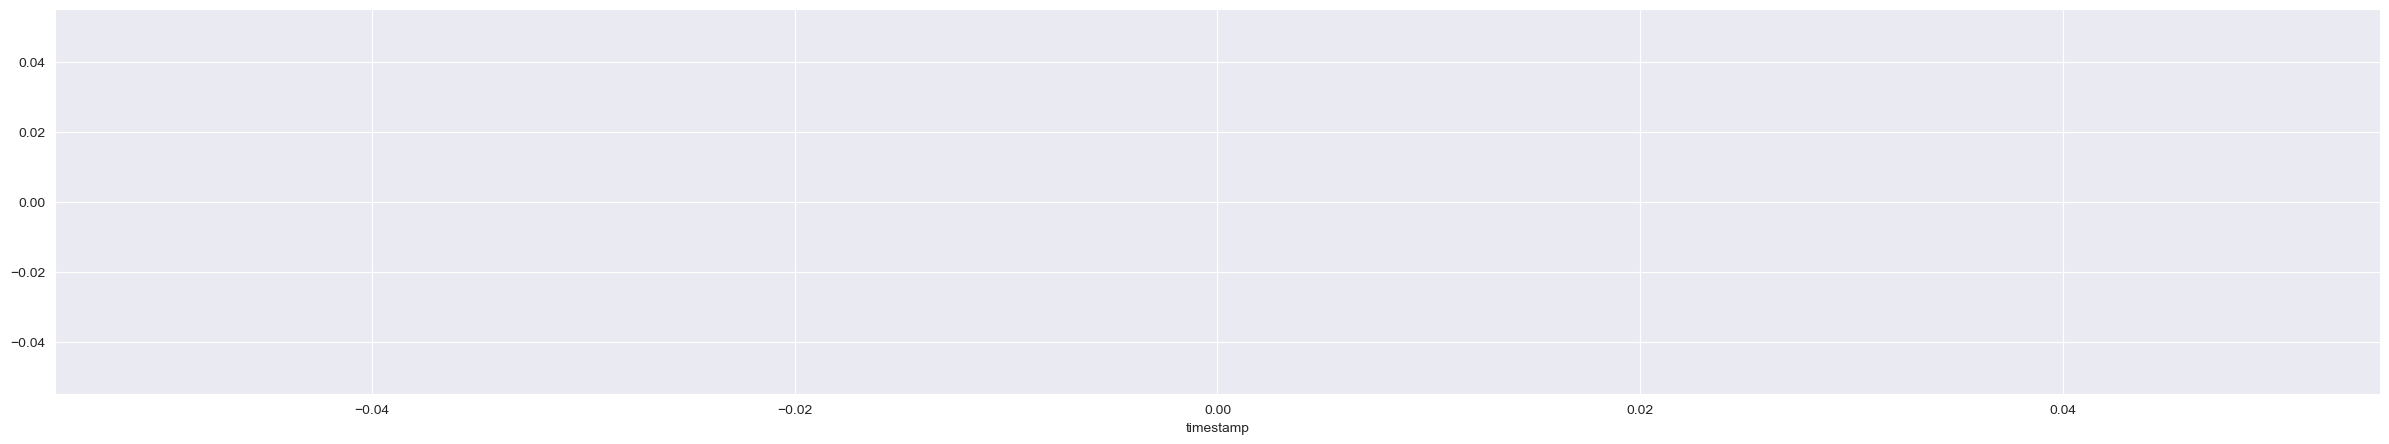

In [80]:
trades_df["quantity"].plot(figsize=(30,5))

<Axes: xlabel='timestamp'>

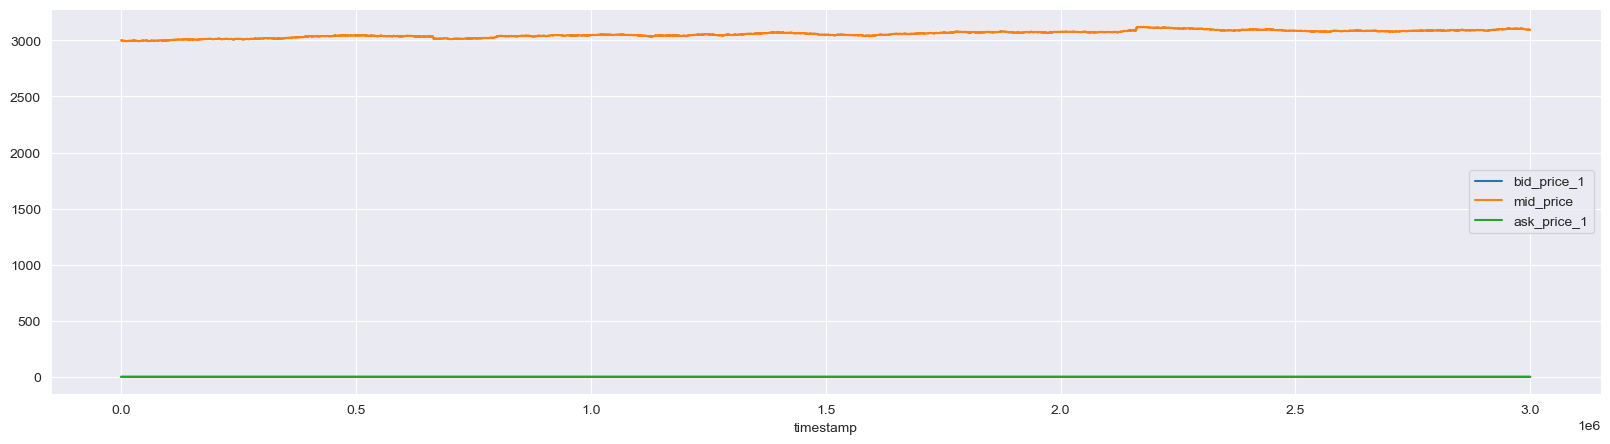

In [85]:
prices_df[["bid_price_1", "mid_price", "ask_price_1"]].plot()

<Axes: xlabel='timestamp'>

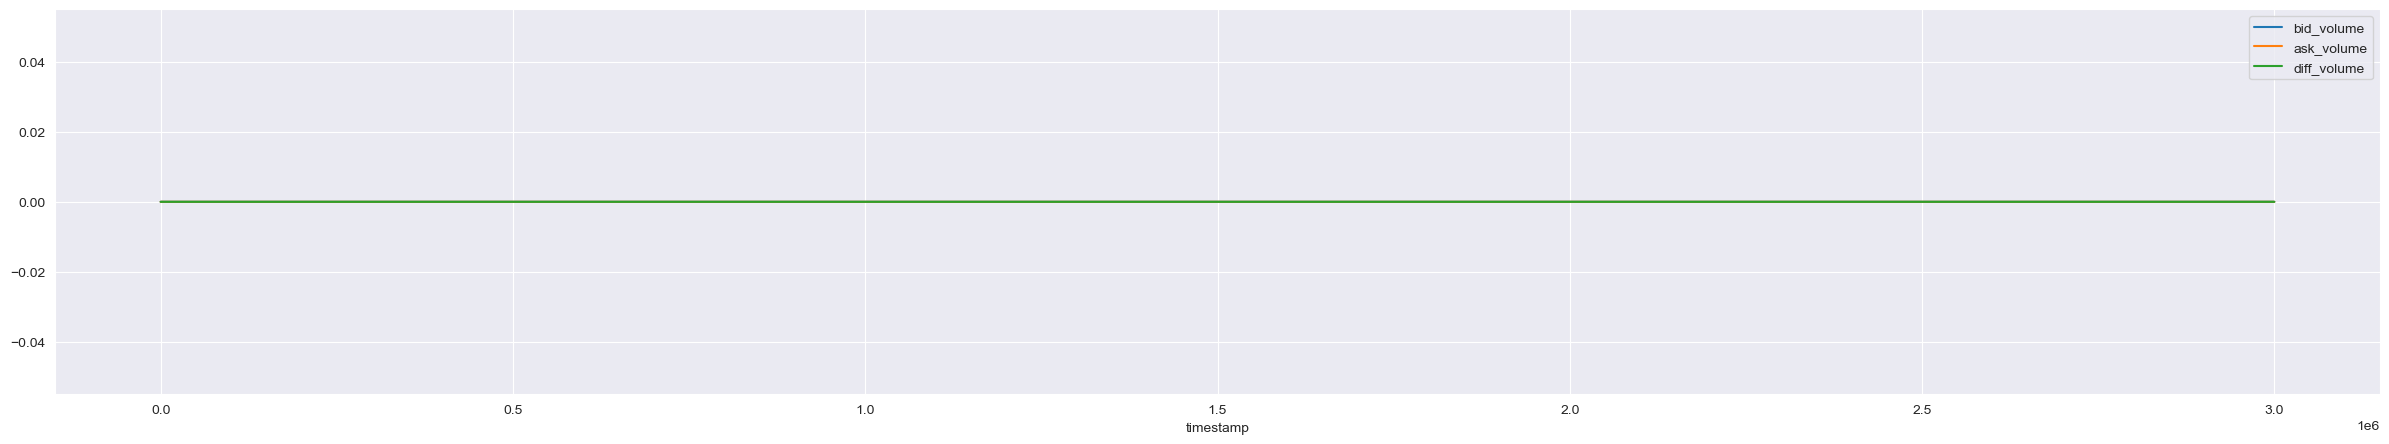

In [82]:
volumes = prices_df[["bid_volume", "ask_volume", "diff_volume"]]
volumes.plot(figsize=(30,5))

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

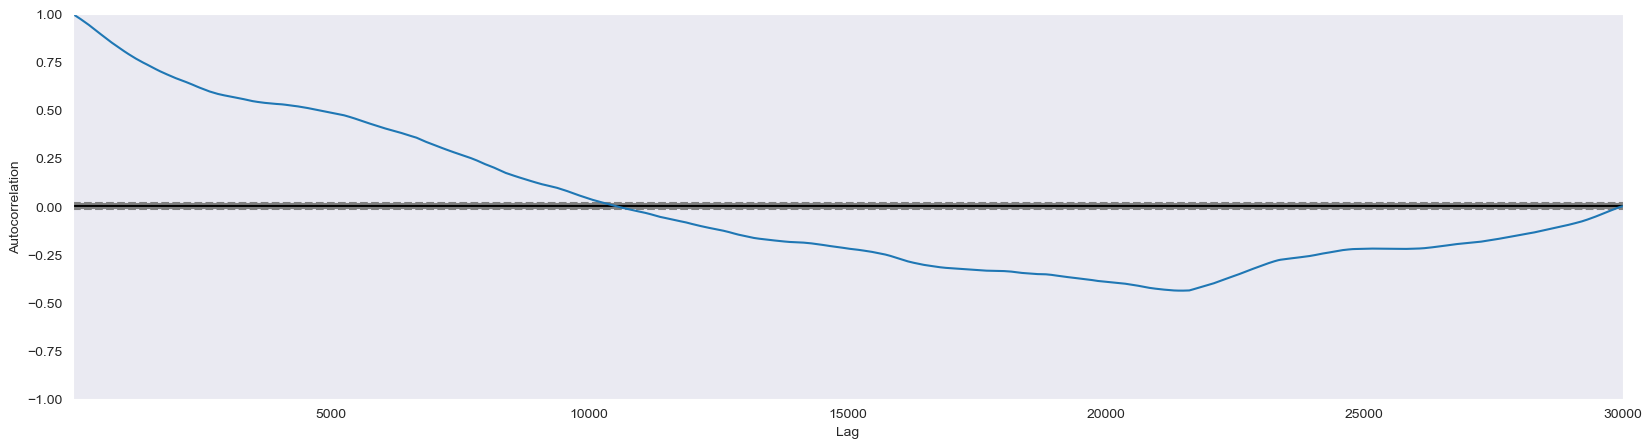

In [87]:
# Used to check randomness. If it's flat then it's random, otherwise 95% or 99% not.
pd.plotting.autocorrelation_plot(prices_df["mid_price"])

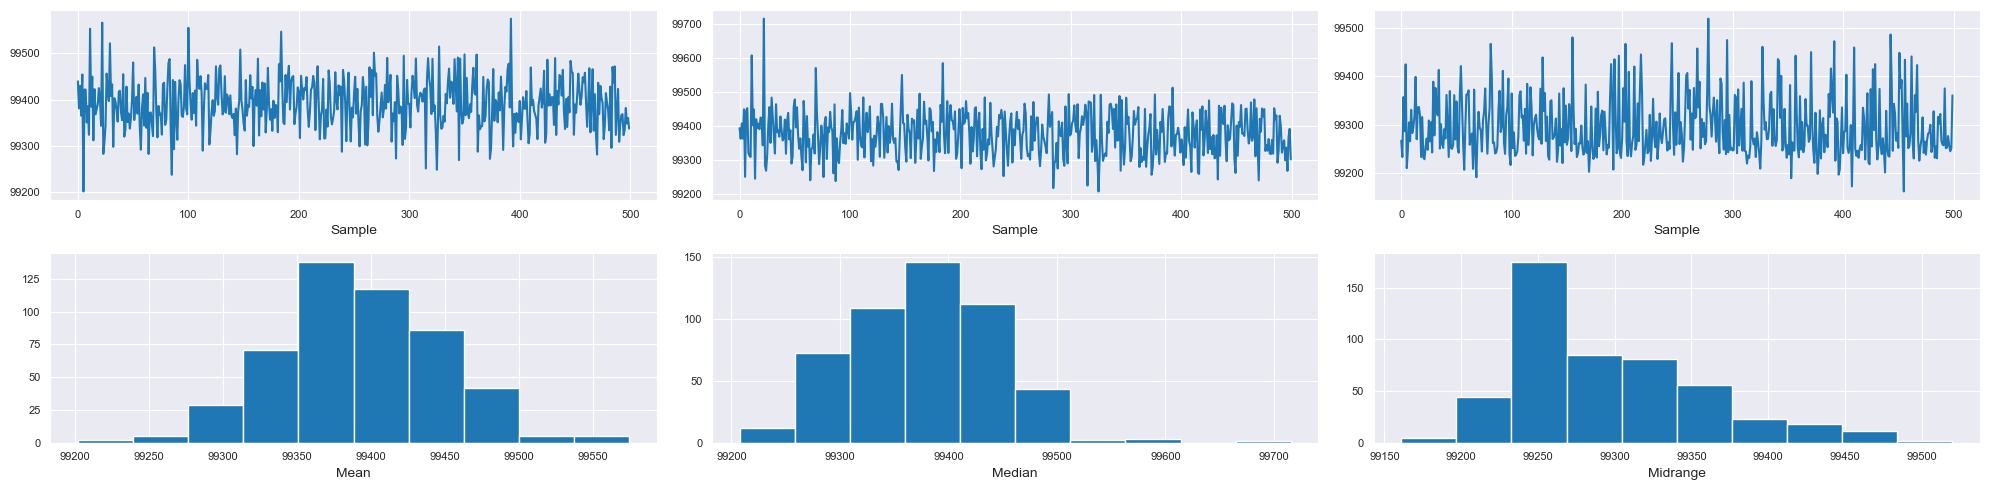

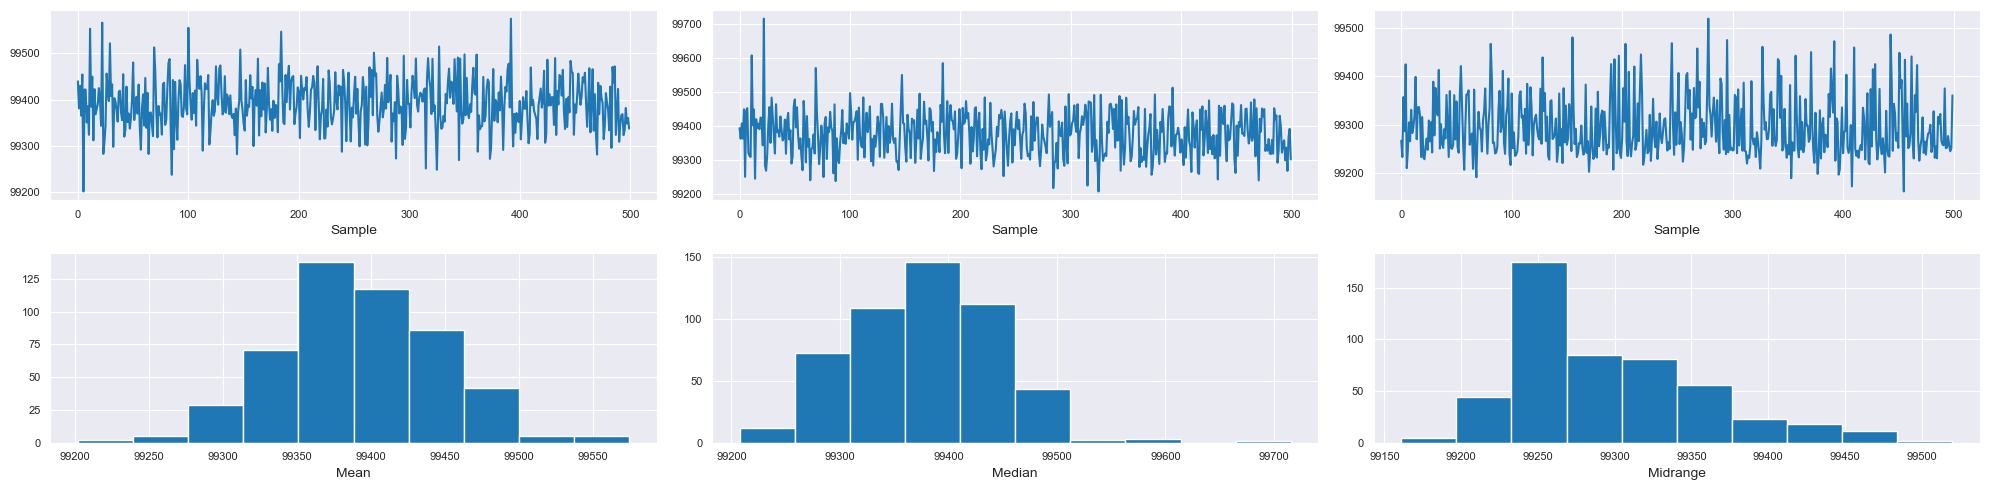

In [70]:
pd.plotting.bootstrap_plot(trades_df["price"])

In [53]:
import scipy.stats

In [54]:
def calculate_starting_price_bidask(day: int):
    result = scipy.stats.linregress(prices_df.index, prices_df["mid_price"])
    print(result)
    return result.slope * (day * 1000000)  + result.intercept

def calculate_starting_price_matched(day: int):
    result = scipy.stats.linregress(trades_df.index, trades_df["price"])
    print(result)
    return result.slope * int(trades_df.shape[0] / END_DAY) * day + result.intercept

calculate_starting_price_bidask(END_DAY), calculate_starting_price_matched(END_DAY)

LinregressResult(slope=-3.6067796260075317e-05, intercept=3971.736157666967, rvalue=-0.7251051431378905, pvalue=0.0, stderr=1.9777143468315332e-07, intercept_stderr=0.34254160939078787)
LinregressResult(slope=-0.06096833306055291, intercept=3971.1449461370953, rvalue=-0.7179314699281723, pvalue=1.679329973895848e-279, stderr=0.0014083111370502073, intercept_stderr=1.4336788370139053)


(3863.532768886741, 3863.59680661828)

In [ ]:
prices_df["mid_price"]

In [ ]:
# Strategy
# Use linear regression w/ moving average to predict fair price (check auto-correlation for most influenced lag time)
# TODO: determine how average time between big trade quantities
